In [1]:
import os
import sys
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm 
import h5py
from pathlib import Path
from torch.utils import data
import librosa

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
class CustomDataset(data.Dataset):

    def __init__(self, file_path, transform=None):
        super().__init__()
        self.data_cache = []
        self.transform = transform
        self.label_count = [0,0,0,0,0,0,0]
        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('coinData_normalized')
        for h5dataset_fp in files:
            print(h5dataset_fp)
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    if gname == 'oneCent':
                        label = 0
                    elif gname == 'twoCent':
                        label = 1
                    elif gname == 'fiveCent':
                        label = 2
                    elif gname == 'twentyCent':
                        label = 3
                    elif gname == 'fiftyCent':
                        label = 4
                    elif gname == 'oneEuro':
                        label = 5
                    elif gname == 'twoEuro':
                        label = 6
                    for dname, ds in tqdm(group.items()):
                        arr = np.pad(np.array(ds, dtype=np.float32), max(int(np.ceil((500000 - len(ds))/2)), 0))
                        self.data_cache.append([label, torch.tensor(arr[:500000]).unsqueeze(0)])
                        #self.data_cache.append([label, torch.tensor((1, ds[:760000]))])
                        
            print(self.data_cache[0][1].size())


    def __getitem__(self, index):
        return self.data_cache[index]

    def __len__(self):
        return len(self.data_cache)

In [4]:
customData = CustomDataset("/home/marcus/Dokumente/munzwurf/")

/home/marcus/Dokumente/munzwurf/coinData_normalized


100%|████████████████████████████████████████| 196/196 [00:00<00:00, 297.44it/s]

torch.Size([1, 500000])


In [5]:
moved_arr = [x - 0.5 for x in customData[100][1][0]]
moved_arr = np.array(moved_arr)

In [6]:
test = librosa.effects.trim(moved_arr, top_db=45)
test[1]

array([     0, 500000])

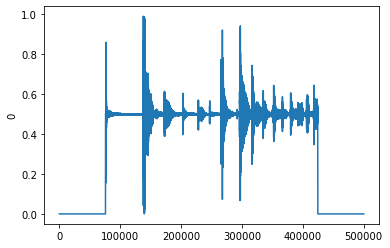

In [7]:
plt.plot(customData[300][1][0])
plt.ylabel(customData[300][0])
plt.show()

In [8]:
random_indices = np.array(np.floor(np.random.rand(100) * 1000), dtype=int)
#tested a bunch of random indices to get a balanced representation of labels
tested_indices = [ 75, 296, 705, 917, 596, 117, 987, 681, 746, 189, 868, 661, 752, 462, 362, 322,  50,  90,
 526,  53, 15, 403, 881, 226, 428, 453,  80, 312, 486, 690, 842, 959, 247, 224, 748, 772,
 620, 617, 108,  96, 212, 649, 866, 707, 956, 772, 234, 339, 166, 954, 602, 935, 707, 717,
  14, 672, 891, 415, 199, 511,   2, 998, 628, 651,  47, 115, 966,  29,   5, 240, 371,  85,
  18, 997,  68, 170, 325, 807, 378, 566, 763, 121,   3, 442, 674, 938, 393, 763, 755, 336,
 419, 408, 104, 923, 580, 530, 859, 371, 957, 535]


In [9]:
train_number = [0,0,0,0,0,0,0]
test_number = [0,0,0,0,0,0,0]
train_data_idx = []
test_data_idx = []
for i in range(len(customData)):
    if train_number[customData[i][0]] < 100:
        train_data_idx.append(i)
        train_number[customData[i][0]] += 1
    elif test_number[customData[i][0]] < 25:
        test_data_idx.append(i)
        test_number[customData[i][0]] += 1


In [10]:
test_labels = np.array([i[0] for i in customData], dtype = int)
train_labels = np.array([customData[i][0] for i in train_data_idx], dtype = int)

In [11]:
train_data = Subset(customData, train_data_idx)
test_data = Subset(customData, test_data_idx)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=4)
test_dataloader  = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=False, num_workers=4)


<BarContainer object of 7 artists>

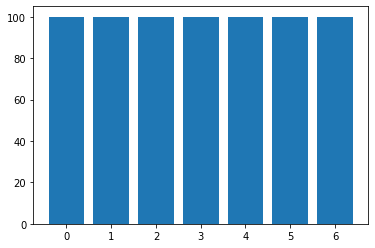

In [12]:
label_count = []
for i in range(7):
    label_count.append(np.count_nonzero(train_labels == i))

plt.bar(range(7), label_count)

In [13]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv1d(2, 4, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv1d(4, 8, kernel_size=3, padding=1) 
        #self.conv4 = nn.Conv1d(8, 16, kernel_size=3, padding=1) 
        #self.conv5 = nn.Conv1d(16, 32, kernel_size=3, padding=1) 
        
        self.fc1   = nn.Linear(32000, 7) 
     
        
        
    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)),5)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv2(x)),5)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv3(x)),5)
        #print(x.shape)
        #x = F.max_pool1d(F.relu(self.conv4(x)),3)
        #print(x.shape)
        #x = F.max_pool1d(F.relu(self.conv5(x)),3)
        #print(x.shape)
        x = torch.flatten(x, 1) 
        #print(x.shape)
        x = F.softmax(self.fc1(x), dim=1)

        
        return x

In [14]:
model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Network(
  (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=32000, out_features=7, bias=True)
)
224147


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
def train(dataloader, optimizer, criterion, model):
    model.train()
    running_loss = 0.0
    j = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [labels, inputs]
        
        inputs = data[1]
        labels = data[0]        
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10), end=" ")
            running_loss = 0.0
            if ((epoch+1) % 50) == 0:
                print(outputs[1:10], labels[1:10])


In [17]:

def test(dataloader, optimizer, criterion, model):   
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels = labels.to(device)
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} ")
                

In [ ]:
for epoch in range(500):  # loop over the dataset multiple times
    train(train_dataloader, optimizer, criterion, model)
    test(test_dataloader, optimizer, criterion, model)
print('Finished Training')




[1,    10] loss: 1.983 Test Error: Accuracy: 14.3%, Avg loss: 1.962510 
[2,    10] loss: 1.993 Test Error: Accuracy: 14.3%, Avg loss: 2.010701 
[3,    10] loss: 1.972 Test Error: Accuracy: 21.7%, Avg loss: 1.949938 
[4,    10] loss: 1.962 Test Error: Accuracy: 13.1%, Avg loss: 1.960445 
[5,    10] loss: 1.962 Test Error: Accuracy: 20.6%, Avg loss: 1.945697 
[6,    10] loss: 1.941 Test Error: Accuracy: 20.0%, Avg loss: 1.946150 
[7,    10] loss: 1.942 Test Error: Accuracy: 14.3%, Avg loss: 1.983722 
[8,    10] loss: 1.954 Test Error: Accuracy: 18.9%, Avg loss: 1.942782 
[9,    10] loss: 1.943 Test Error: Accuracy: 19.4%, Avg loss: 1.953031 
[10,    10] loss: 1.933 Test Error: Accuracy: 20.6%, Avg loss: 1.951477 
[11,    10] loss: 1.925 Test Error: Accuracy: 18.3%, Avg loss: 1.952074 
[12,    10] loss: 1.913 Test Error: Accuracy: 20.6%, Avg loss: 1.947404 
[13,    10] loss: 1.914 Test Error: Accuracy: 21.1%, Avg loss: 1.935630 
[14,    10] loss: 1.899 Test Error: Accuracy: 21.1%, Avg los

[100,    10] loss: 1.576 tensor([[9.1458e-06, 1.8421e-02, 1.5132e-02, 1.2200e-11, 9.6644e-01, 1.0098e-12,
         3.4642e-11],
        [6.6740e-02, 9.3309e-01, 1.4292e-09, 5.0781e-11, 1.1336e-05, 1.6190e-04,
         2.4068e-10],
        [9.0358e-01, 1.1132e-02, 3.2951e-03, 1.5069e-09, 8.1989e-02, 2.0075e-08,
         3.1330e-09],
        [3.2766e-03, 9.8167e-01, 1.0804e-02, 6.8199e-09, 4.2356e-03, 1.4432e-05,
         1.9114e-08],
        [9.4472e-02, 5.7165e-03, 1.3441e-04, 6.9186e-08, 2.2225e-03, 8.9745e-01,
         1.7302e-07],
        [1.6738e-06, 6.0815e-04, 6.5129e-03, 7.1681e-12, 9.9288e-01, 9.0954e-13,
         1.2584e-11],
        [1.1036e-01, 6.6182e-01, 1.1691e-01, 1.6713e-07, 1.0861e-01, 2.2977e-03,
         5.0152e-07],
        [2.8161e-03, 9.9214e-01, 3.0476e-03, 1.3218e-07, 1.9580e-03, 3.5832e-05,
         1.4739e-07],
        [1.3667e-06, 3.1910e-02, 9.6589e-01, 3.6079e-10, 2.1960e-03, 1.1032e-12,
         3.7804e-10]], device='cuda:0', grad_fn=<SliceBackward>) tenso

[183,    10] loss: 1.480 Test Error: Accuracy: 24.6%, Avg loss: 1.872709 
[184,    10] loss: 1.494 Test Error: Accuracy: 27.4%, Avg loss: 1.860237 
[185,    10] loss: 1.489 Test Error: Accuracy: 25.7%, Avg loss: 1.864703 
[186,    10] loss: 1.490 Test Error: Accuracy: 25.1%, Avg loss: 1.880505 
[187,    10] loss: 1.500 Test Error: Accuracy: 26.3%, Avg loss: 1.883410 
[188,    10] loss: 1.495 Test Error: Accuracy: 28.0%, Avg loss: 1.857654 
[189,    10] loss: 1.503 Test Error: Accuracy: 24.6%, Avg loss: 1.875712 
[190,    10] loss: 1.495 Test Error: Accuracy: 25.1%, Avg loss: 1.876424 
[191,    10] loss: 1.495 Test Error: Accuracy: 26.3%, Avg loss: 1.899812 
[192,    10] loss: 1.495 Test Error: Accuracy: 24.6%, Avg loss: 1.895396 
[193,    10] loss: 1.499 Test Error: Accuracy: 26.9%, Avg loss: 1.865127 
[194,    10] loss: 1.497 Test Error: Accuracy: 26.3%, Avg loss: 1.845285 
[195,    10] loss: 1.485 Test Error: Accuracy: 26.3%, Avg loss: 1.865416 
[196,    10] loss: 1.499 Test Error: A

[266,    10] loss: 1.472 Test Error: Accuracy: 32.6%, Avg loss: 1.843355 
[267,    10] loss: 1.482 Test Error: Accuracy: 32.6%, Avg loss: 1.863431 
[268,    10] loss: 1.482 Test Error: Accuracy: 30.3%, Avg loss: 1.851011 
[269,    10] loss: 1.488 Test Error: Accuracy: 29.1%, Avg loss: 1.842695 
[270,    10] loss: 1.483 Test Error: Accuracy: 32.0%, Avg loss: 1.852490 
[271,    10] loss: 1.481 Test Error: Accuracy: 30.3%, Avg loss: 1.872345 
[272,    10] loss: 1.482 Test Error: Accuracy: 29.7%, Avg loss: 1.853761 
[273,    10] loss: 1.478 Test Error: Accuracy: 30.3%, Avg loss: 1.835184 
[274,    10] loss: 1.472 Test Error: Accuracy: 31.4%, Avg loss: 1.853136 
[275,    10] loss: 1.489 Test Error: Accuracy: 29.1%, Avg loss: 1.849606 
[276,    10] loss: 1.472 Test Error: Accuracy: 30.3%, Avg loss: 1.851895 
[277,    10] loss: 1.491 Test Error: Accuracy: 28.0%, Avg loss: 1.861298 
[278,    10] loss: 1.483 Test Error: Accuracy: 26.3%, Avg loss: 1.902525 
[279,    10] loss: 1.495 Test Error: A

Test Error: Accuracy: 30.3%, Avg loss: 1.853639 
[351,    10] loss: 1.469 Test Error: Accuracy: 28.6%, Avg loss: 1.859889 
[352,    10] loss: 1.458 Test Error: Accuracy: 28.0%, Avg loss: 1.863470 
[353,    10] loss: 1.476 Test Error: Accuracy: 28.6%, Avg loss: 1.857377 
[354,    10] loss: 1.462 Test Error: Accuracy: 30.3%, Avg loss: 1.870883 
[355,    10] loss: 1.463 Test Error: Accuracy: 29.7%, Avg loss: 1.858239 
[356,    10] loss: 1.469 Test Error: Accuracy: 28.6%, Avg loss: 1.874659 
[357,    10] loss: 1.460 Test Error: Accuracy: 28.6%, Avg loss: 1.864140 
[358,    10] loss: 1.466 Test Error: Accuracy: 30.3%, Avg loss: 1.839069 
[359,    10] loss: 1.465 Test Error: Accuracy: 28.6%, Avg loss: 1.868205 
[360,    10] loss: 1.458 Test Error: Accuracy: 29.7%, Avg loss: 1.844937 
[361,    10] loss: 1.465 Test Error: Accuracy: 29.1%, Avg loss: 1.868947 
[362,    10] loss: 1.461 Test Error: Accuracy: 29.1%, Avg loss: 1.865953 
[363,    10] loss: 1.467 Test Error: Accuracy: 28.6%, Avg loss: